# Numerical simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
import egttools as egt

In [3]:
egt.Random.init()
seed = egt.Random._seed

In [4]:
# Payoff matrix
V = 2; D = 3; T = 1
A = np.array([
        [ (V-D)/2, V],
        [ 0      , (V/2) - T],
    ])

In [5]:
A

array([[-0.5,  2. ],
       [ 0. ,  0. ]])

## Estimate numerically the stationary distribution

You can use `egttools` to estimate numerically the stationary distribution. All you need to specify is the number of independent runs (simulations) that will be executed and afterwards averaged to obtain the final estimation; the length of each run (the number of generations); the transitory period (a number of generations that will not be taken into account to compute the stationary distribution - this transitory period will depend on the problem that is being studied); the intensity of selection ($\beta$); and the probability of a mutation occuring ($\mu$).

In [6]:
game = egt.games.NormalFormGame(1, A)

In [7]:
Z = 100
x = np.arange(0, Z+1)/Z

In [8]:
evolver = egt.numerical.PairwiseMoran(Z, game, 1000000)

In [9]:
Z = 100
x = np.arange(0, Z+1)/Z
evolver.pop_size = Z

In [10]:
dist = evolver.estimate_stationary_distribution(10, int(1e6), int(1e3), 1, 1e-3)

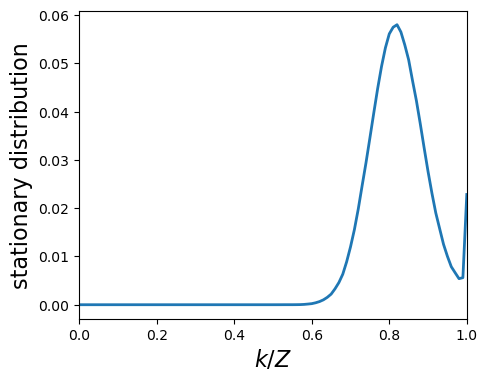

In [11]:
# We need to reverse, since in this case we are starting from the case
# where the number of Haws is 100%, because of how we map states
fig, ax = plt.subplots(figsize=(5, 4))
fig.patch.set_facecolor('white')
lines = ax.plot(x, list(reversed(dist)))
plt.setp(lines, linewidth=2.0)
ax.set_ylabel('stationary distribution',size=16)
ax.set_xlabel('$k/Z$',size=16)
ax.set_xlim(0, 1)
plt.show()

### We can also plot a single run

Note: when looking at single runs bewhare that at the moment the outcome is returned in a dense array (this might change soon). This means that if you want to look at a large number of generations, you will need a lot of memmory. In the future, we will add the option to return only the last $t$ generations.

In [12]:
output = evolver.run(int(1e6), 1, 1e-3, [0, Z])

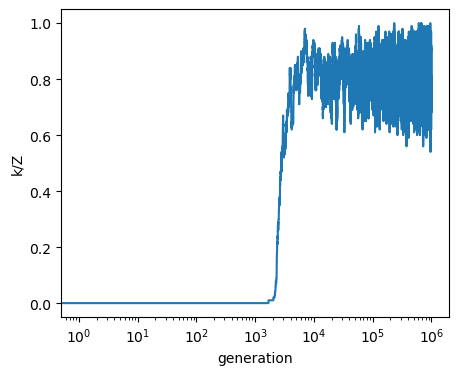

In [13]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(output[:, 0]/Z)
ax.set_ylabel('k/Z')
ax.set_xlabel('generation')
ax.set_xscale('log')
plt.show()

### And can visualize what happens if we start several runs from random points in the simplex

In this case, since we have a 1 dimensional simplex (only 2 strategies) you simply need to generate random integers. When you study problems with more dimensions, you will need to make use of `egttools.sample_simplex` and `egttools.calculate_nb_states` to be able to sample the simplex uniformly. All you would need to do is to draw random intergers uniformly in the range `[0, total_nb_states)` and then use `egttools.sample_simplex` to obtain the state in discrete barycentric coordinates.

In [14]:
init_states = np.random.randint(0, Z+1, size=10, dtype=np.uint64)

In [15]:
output = []
for i in range(10):
    output.append(evolver.run(int(1e6), 1, 1e-3, 
                              [init_states[i], Z - init_states[i]]))

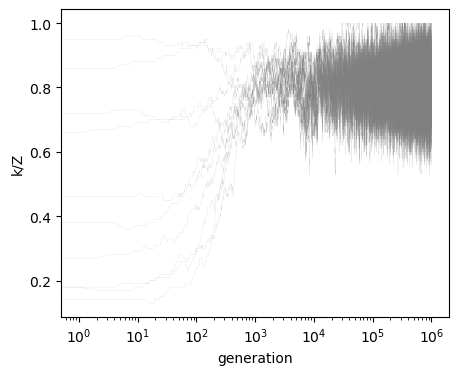

In [16]:
# Plot each year's time series in its own facet
fig, ax = plt.subplots(figsize=(5, 4))

for run in output:
    ax.plot(run[:, 0]/Z, color='gray', linewidth=.1, alpha=0.6) 
ax.set_ylabel('k/Z')
ax.set_xlabel('generation')
ax.set_xscale('log')

### And we can also compare how far our approximations are from the analytical results

As you will be able to see in the results bellow, the approximation (for this quite simple problem) is good enough for most values of $\beta$. However, the biggest errors occur when $\beta$ is low, so bewhare that you might need to increase the number of generations or the number of independent runs (or both) in this case. In the future, we plan to have an adaptive method to stop the simulation when the approximation si good enough (e.g., when th KL-divergence between estimations of the stationary distribution does not change below a certain tolerance after a certain number of generations). 

In [17]:
# We do this for different betas
betas = np.logspace(-4, 1, 50)

In [ ]:
stationary_points = []
for i in range(len(betas)):
    stationary_points.append(evolver.estimate_stationary_distribution(30, int(1e6), int(1e3), 
                                                                      betas[i], 1e-3))
stationary_points = np.asarray(stationary_points)

In [ ]:
# Now we estimate the probability of Cooperation for each possible state
state_frequencies = np.arange(0, Z+1) / Z
coop_level = np.dot(state_frequencies, stationary_points.T)

In [ ]:
# Finnally we do the same, but for the analytical results
from egttools.analytical import StochDynamics

In [ ]:
analytical_evolver = egt.analytical.StochDynamics(2, A, Z, mu=1e-3)

In [ ]:
stationary_points_analytical = []
for i in range(len(betas)):
    stationary_points_analytical.append(analytical_evolver.calculate_stationary_distribution(betas[i]))
stationary_points_analytical = np.asarray(stationary_points_analytical)

In [ ]:
# Now we estimate the probability of Cooperation for each possible state
coop_level_analytical = np.dot(1 - state_frequencies, stationary_points_analytical.T)

# Now we estimate the probability of Cooperation for each possible state
coop_level_analytical = np.dot(1 - state_frequencies, stationary_points_analytical.T)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mse = mean_squared_error(1 - coop_level_analytical, coop_level)

In [ ]:
import seaborn as sns

In [ ]:
# Finally, we plot and compare visually (and check how much error we get)
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 3})
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(betas, 1 - coop_level_analytical, marker='x', label="analytical")
ax.scatter(betas, coop_level, marker='o', label="numerical")
ax.text(0.01, 0.5, 'MSE = {0:.3e}'.format(mse), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
ax.legend(bbox_to_anchor=(0.5, 0., 0.5, 0.5))
ax.set_xlabel(r'$\beta$', fontsize=15)
ax.set_ylabel('Frequency of Doves', fontsize=15)
ax.set_xscale('log')
sns.despine()
plt.show()